# Spotify Song Recommendation

## 1.- Cleaning data

In [1]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from pyearth import Earth

In [2]:
# Read the csv file containing songs and metadata
p_genres = "genres_v2.csv"
df_genres = pd.read_csv(p_genres, low_memory=False)
df_genres.shape

In [5]:
# EDA 
df_genres.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
genre                object
song_name            object
Unnamed: 0          float64
title                object
dtype: object

In [6]:
df_genres[['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title', 'genre']].head(2)

type                      id  \
0  audio_features  2Vc6NJ9PW9gD9q343XFRKx   
1  audio_features  7pgJBLVz5VmnL7uGHmRj6p   

                                    uri  \
0  spotify:track:2Vc6NJ9PW9gD9q343XFRKx   
1  spotify:track:7pgJBLVz5VmnL7uGHmRj6p   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...   
1  https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...   

                                        analysis_url            song_name  \
0  https://api.spotify.com/v1/audio-analysis/2Vc6...  Mercury: Retrograde   
1  https://api.spotify.com/v1/audio-analysis/7pgJ...            Pathology   

   Unnamed: 0 title      genre  
0         NaN   NaN  Dark Trap  
1         NaN   NaN  Dark Trap

In [7]:
# Selecting only numerical features
features = ['danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
df = df_genres[features]

## 2.- Scaling data

In [8]:
# Scaling and centering the data
scaler = StandardScaler()
scaler.fit(np.array(df))

StandardScaler()

In [60]:
df_scaled = pd.DataFrame(scaler.transform(np.array(df)), columns=features)
df_scaled.head(3)

danceability    energy  loudness      mode  speechiness  acousticness  \
0      1.223608  0.280079 -0.305514  0.905517     2.246552     -0.212853   
1      0.508480 -1.466185 -0.259954  0.905517    -0.453057      1.784518   
2      1.344924  0.709845  0.572039  0.905517    -0.588592     -0.482135   

   instrumentalness  liveness   valence     tempo  duration_ms  time_signature  
0         -0.727231 -0.902637  0.136790  0.398876    -1.226992        0.102184  
1         -0.763370 -0.547231 -0.999586 -1.358564    -0.256796        0.102184  
2         -0.763359  0.899456 -1.363655  2.959861    -1.476787        0.102184

## 3.- Cheking for correlations
It is required to check our data for crucial correlations among the variables, because this can introduce variability to the model when we perform clustering and the pca.

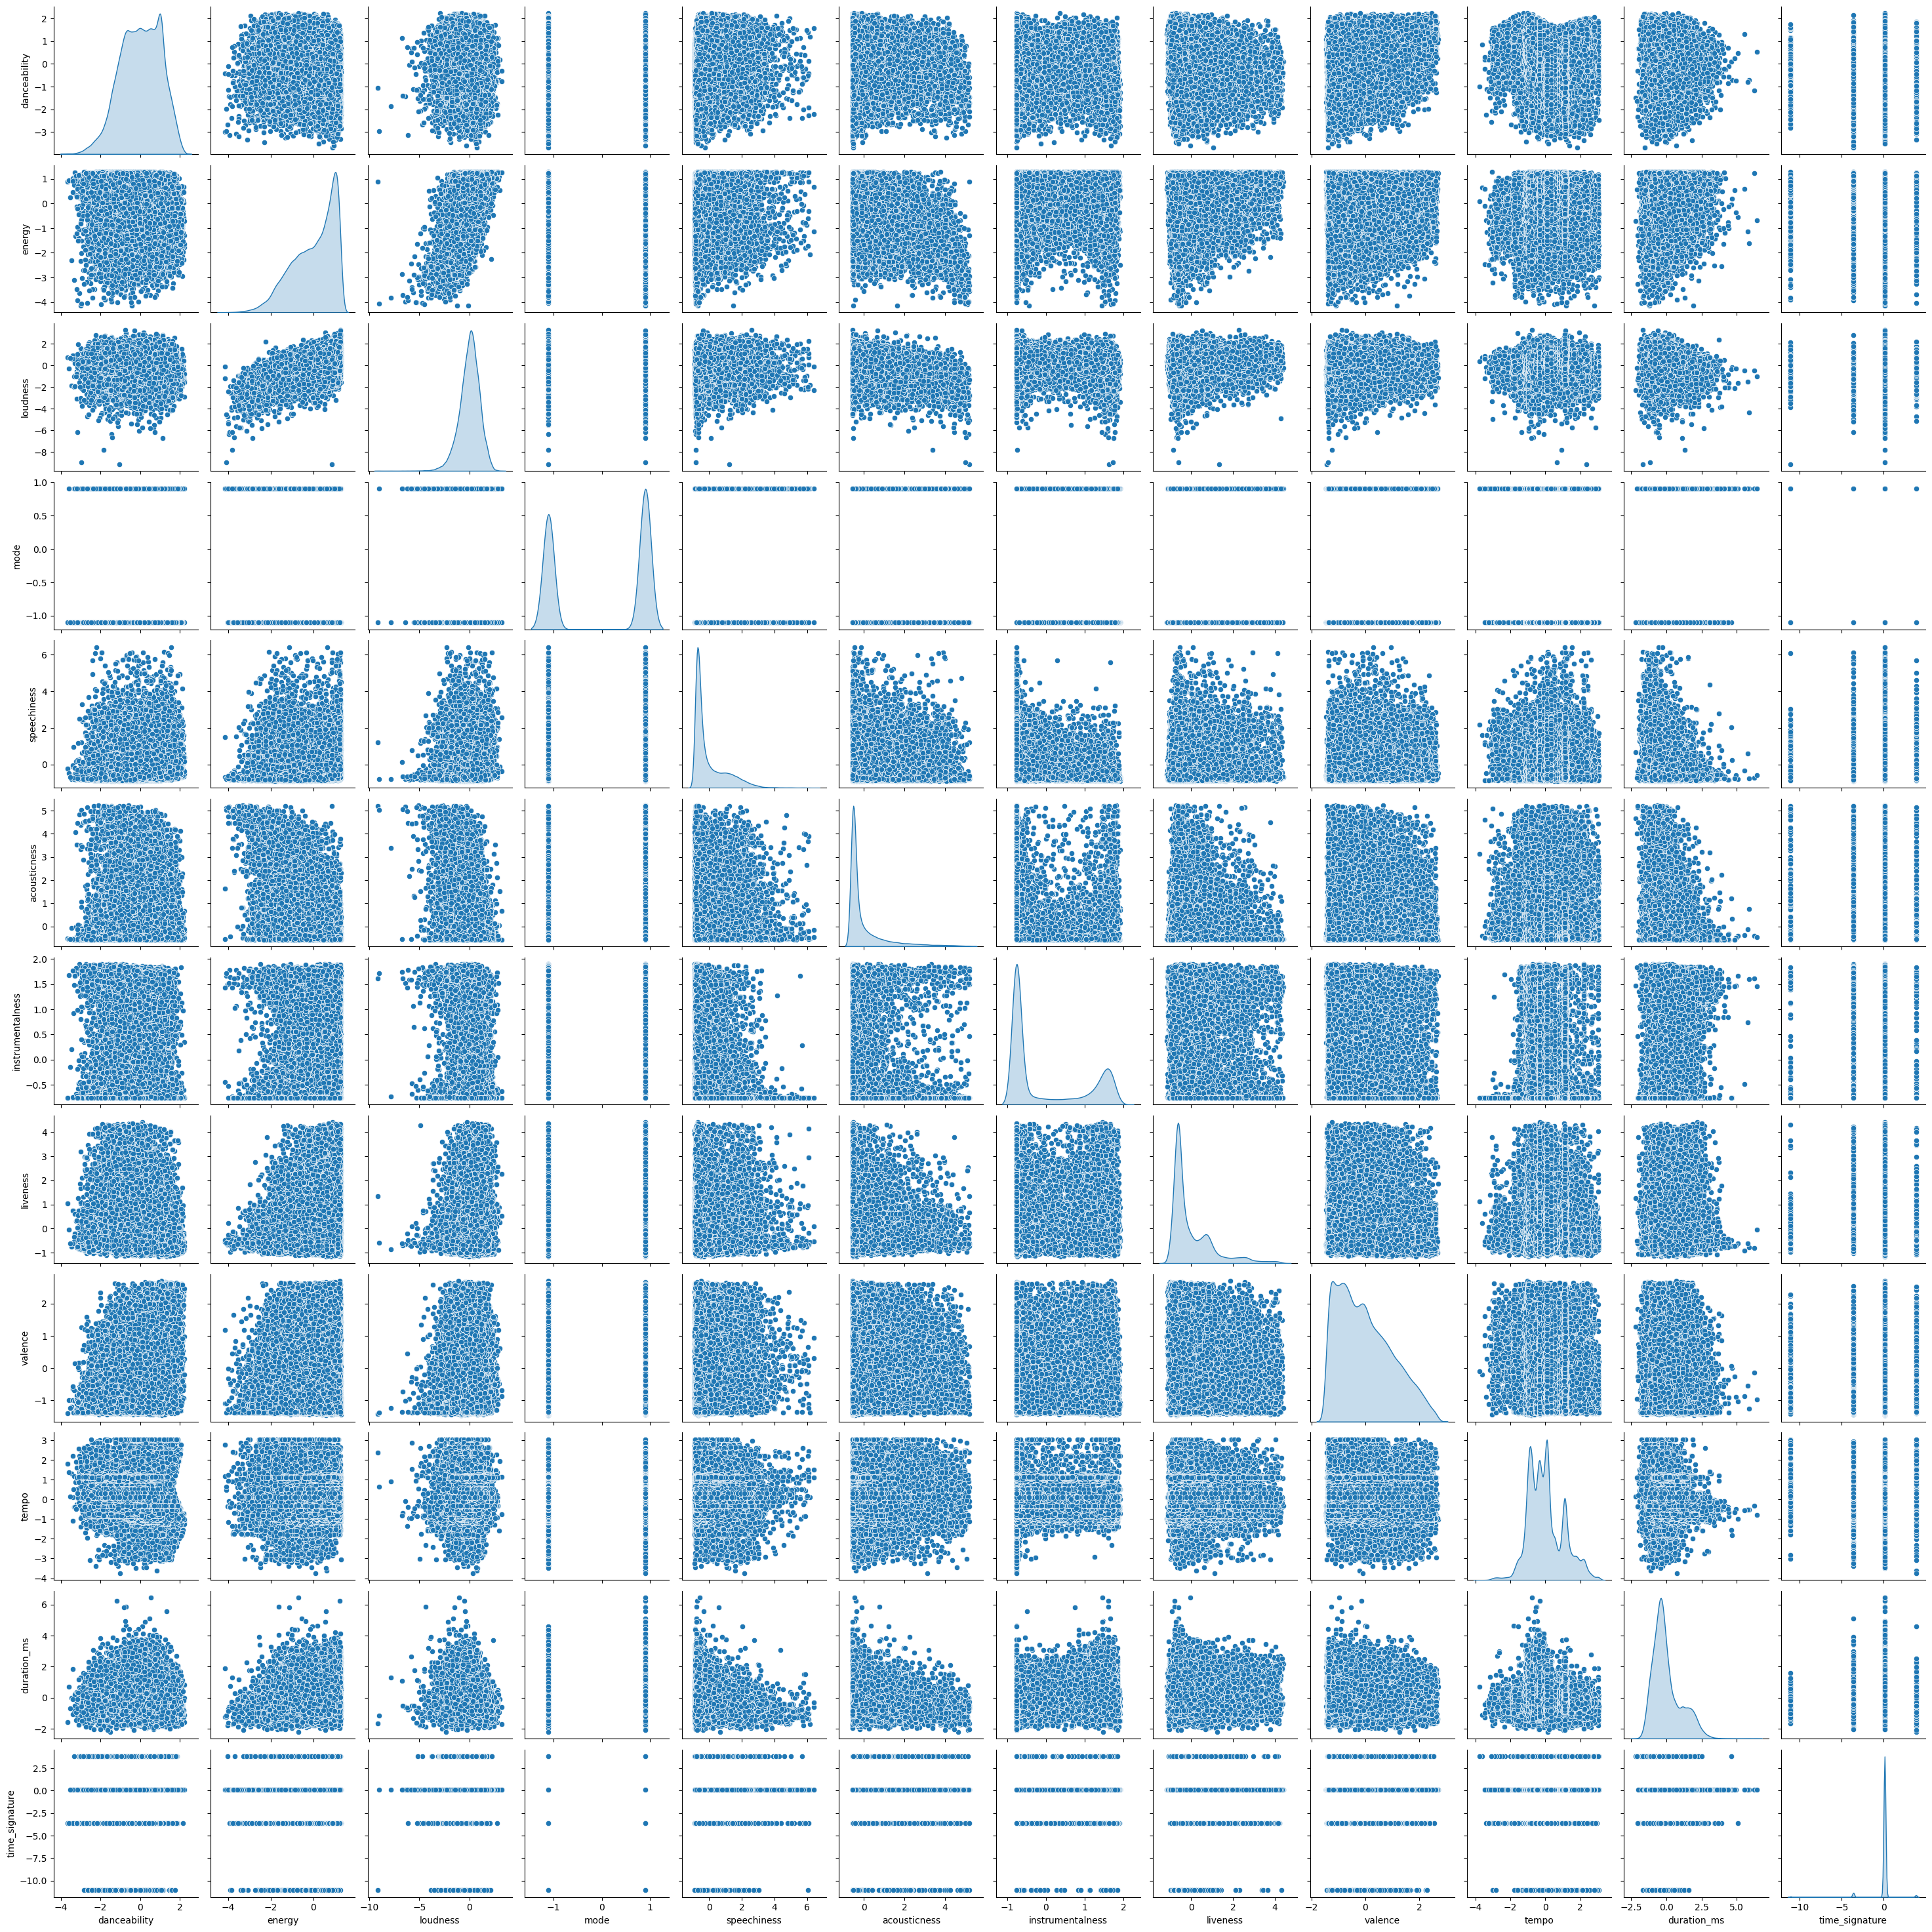

In [11]:
sns.pairplot(df_scaled, diag_kind='kde')

As it can be seen in the former figure, at first sight, it doesn't shows a visible tendency.

## 4.- Clustering
To obtain the better results, we must find the better number of clusters to separate the data. Using a MARS regression can help us to find this value, corresponding to a major difference between the set of points.

In [42]:
#Finding optimal number of clusters
from scipy.spatial.distance import cdist
clusters = range(1,31)
mean_dist = []

for k in clusters:
    model = KMeans(n_clusters=k, n_init=5, random_state=0)
    model.fit(df_scaled)
    prediction = model.predict(df_scaled)
    mean_dist.append(sum(np.min(cdist(df_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / df_scaled.shape[0])

In [43]:
# MARS Model to detect the elbow
reg_mars = Earth(penalty=3, max_degree=1)
reg_mars.fit(np.array(clusters).reshape(-1,1), np.array(mean_dist).reshape(-1,1))
pred_mars = reg_mars.predict(clusters)

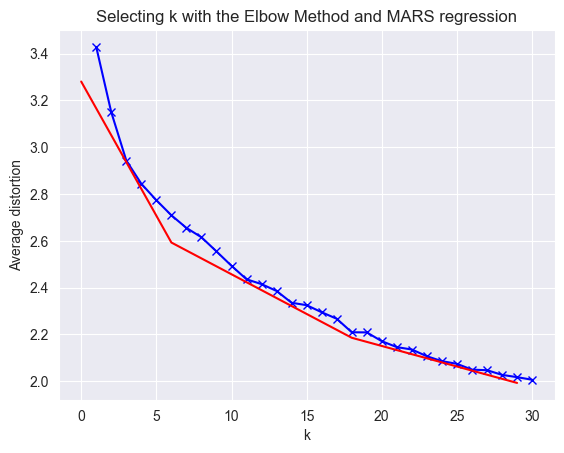

In [44]:
plt.plot(clusters, mean_dist, 'bx-')
plt.plot(pred_mars, color='red')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method and MARS regression')
plt.show();

In [49]:
model = KMeans(n_clusters=6, n_init=5, random_state=0)
model.fit(df_scaled)
df_scaled['cluster_label'] = model.predict(df_scaled)

In [61]:
# model.inertia_

In [62]:
# Visualizing the Clusters with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
song_embedding = pca.fit_transform(df_scaled)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['cluster'] = df_scaled['cluster_label']

KeyError: 'cluster_label'

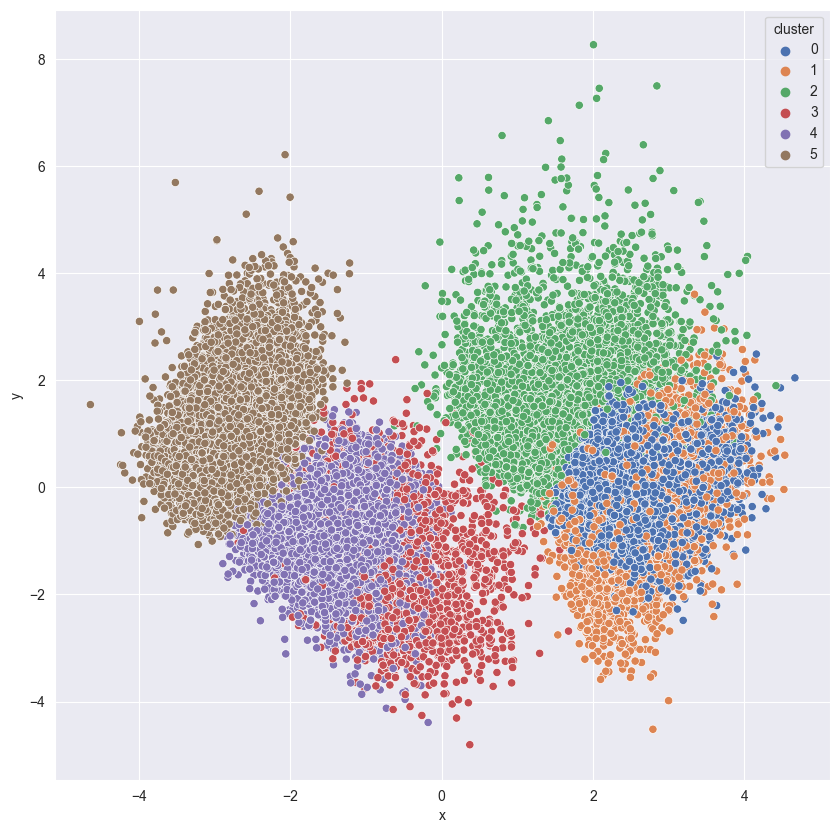

In [52]:
sns.set_style('darkgrid')
ax, fig = plt.subplots(figsize=(10,10))
fig = sns.scatterplot(data=projection, x='x', y='y', hue='cluster', palette="deep")

## 5.- Prediction model

In [53]:
import csv

# Opening csv containing the credentials of the spotify app
with open('Client_ID.CSV', newline='') as ID_file:
    ID_cred = csv.reader(ID_file, delimiter=',', quotechar='|')
    for row in ID_file:
        CLIENT_ID = row.split(",")[0]
        CLIENT_SECRET = row.split(",")[1]

In [54]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import os

# Calling the spotify app to sp client
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET))

In [55]:
# Gathering required values from the songs
def find_song(name, artist, features):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} artist: {}'.format(name, artist), limit=1)
    
    if results['tracks']['items'] == []:
        return None
    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
    
    for element in features:
        song_data[element] = [audio_features[element]]
        
    return pd.DataFrame(song_data)

In [56]:
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

def get_mean_vector(song_list):
    song_vectors = []
    for song in song_list:
        song_data = find_song(song, song_list[song], features)
        if song_data is None:
            continue
        song_vectors.append(song_data.values)  
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)

def recommend_songs(song_list, spotify_data, n_songs=2):
    song_center = get_mean_vector(song_list)
    song_scaled = scaler.transform(song_center)
    scaled_data = np.array(df_scaled.drop(columns='cluster_label'))
    
    distances = cdist(song_scaled, scaled_data, 'cosine')    
    selected_song = np.argsort(distances)[:, :n_songs][0]  
    index = list(selected_song)
    rec_songs = spotify_data.iloc[index].copy()
    rec_songs['distance'] = distances[0,index]
    
    return rec_songs[['song_name', 'distance']]

## 6.- Testing the model

In [57]:
playlist = {'As It Was':'Harry Styles',
            'Levitating':'Dua Lipa',
            'Safe And Sound':'Capital Cities',
            'Rhinestone Eyes':'Gorillaz'
           }

In [58]:
# playlist = {'Enter Sandman':'Metallica',
#             'Chop Suey!':'System Of A Down',
#             'One':'Metallica',
#             'Toxicity':'System Of A Down'
#            }

In [59]:
uwu = recommend_songs(playlist, df_genres, n_songs = 5);
print(uwu)

         song_name  distance
12701   Hard Times  0.103427
13867   Hard Times  0.103427
16177   Your Heels  0.110783
18155         Maps  0.111382
12608  Stacy's Mom  0.116919
